# Projekt **"Kaufen oder Warten"**
Die Situation kennen alle, die ab und zu Flugtickets kaufen: Sollte man besser warten, weil der Preis vielleicht noch fällt, oder sollte man kaufen? Insbesondere bei der Fluggesellschaft, um die es in diesem Projekt geht, sind scheinbar erratische Preisveränderungen bekannt. Die übliche Regel "je früher, desto besser" ist hier oft nicht die beste Empfehlung.

## Datenbeschreibung
Der Datensatz train_set.csv enthält Preisanfragen zu bestimmten Zeitpunkten für Flüge. Es werden nur zwei verschiedene Strecken in beiden Richtungen betrachtet: zwischen London Stansted und Berlin Schönefeld sowie zwischen London Stansted und Frankfurt.

Die folgenden Merkmale sind enthalten:

Request_Date: Datum und Uhrzeit der Preisanfrage
Flight_Date: Datum des Flugs
Departure_hour: Gerundete Abflugszeit
flight_unique_id: Eindeutige ID für den Flug
route_abb: Abkürzung der Flugroute
Price_In_Eur: Flugpreis
min_future_price_in_Eur: Minimaler Flugpreis für die flight_unique_id über alle zukünftigen Request_Dates
buy: 1 = kaufen, 0 = warten (vorherzusagende Klasse)
Die buy-Klasse wird wie folgt berechnet: if Price_In_Eur - min_future_price_in_Eur <= 0 then 1 else 0

## Aufgabe
Sie sollen ein Modell für eine Kaufempfehlung aus den Daten lernen. Interpretieren Sie ein Zeile in dem Datensatz als eine Preisabfrage, die Sie als Kunde durchführen. Das zu lernende Modell soll Ihnen dann empfehlen, zu dem Preis zu kaufen oder besser zu warten.

Für den ersten Teil der Arbeit überlegen Sie sich, wie Sie solch ein Modell in der Praxis gestalten und anwenden würden. Versetzen Sie sich dazu in die Lage eines Kunden und/oder in die Lage eines Unternehmens. Was könnte bei letzterem das Geschäftsmodell sein?

Welchen Einfluss haben diese Überlegungen auf das Konzept des zu lernenden Modells?

Halten Sie sich beim Vorgehen bitte an die allgemeinen Schritte, die ich oben für alle Projekte beschrieben habe.

## Modellgüte
Benutzen Sie zunächst einfache Vorhersagegenauigkeit zur Beurteilung der Modellgüte (Accuracy). Messen Sie also die Anzahl der richtigen Entscheidungen (Kaufen oder Warten) durch die Anzahl aller Entscheidungen.

Überlegen Sie dann, wie man aus Sicht eines Kunden bzw. Ihres Geschäftsmodells die Güte der Kaufempfehlungen messen sollte. Hier spielen sicher monetäre Überlegungen und Kundenzufriedenheit eine größere Rolle als nur möglichst genaue Empfehlungen. Denken Sie hierbei auch daran, dass man sich als Kunde nicht dem Stress aussetzen möchte, ständig Preise abzufragen.

Sie werden Ihre Ideen bei der Zwischenpräsentation vorstellen und diskutieren. Sie haben dann die Gelegenheit, für den zweiten Teil der Arbeit (Bauen der Modelle) Ihre Überlegungen basierend auf den Diskussionen anzupassen und auch Ideen von anderen Gruppen aufzunehmen.

## Wettbewerb
Es gibt einen Testdatensatz (s.u.), der dasselbe Datenformat wie der Trainingsdatensatz aufweist - nur die Spalten min_future_price_in_Eur und buy fehlen, da diese in der Anwendungssituation nicht bekannt wären. Für die Abgabe der Arbeit sollen Sie Ihre Modelle auf den Testdatensatz anwenden und das Ergebnis mit abgeben (Beschreibung siehe beim Abgabetermin weiter oben in Moodle). Wir werden die besten Modelle als Sieger küren, wenn alle Gruppen abgegeben haben.

Dazu werden wir zwei verschiedene Gütemaße betrachten: die einfache Genauigkeit (Accuracy) und das monetäre Gütemaß, auf das wir uns noch einigen werden.

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import warnings
sns.set_theme(style="whitegrid")
from datetime import datetime
from dateutil import tz

In [2]:
# Trainingsdaten in einer Dataframme einlesen
flug_df = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/train_set.csv")
# Die fünf ersten Objekte ausgeben
flug_df.head()

,index,Request_Date,Flight_Date,Departure_hour,flight_unique_id,route_abb,Price_In_Eur,min_future_price_in_Eur,buy
0,1,2019-06-03T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,208.07,259.07,1
1,2,2019-06-03T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
2,3,2019-06-04T11:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
3,4,2019-06-04T23:00:00Z,2019-06-05,19,2019-06-05 FR 146,SXF-STN,259.07,259.07,1
4,5,2019-06-03T11:00:00Z,2019-06-05,21,2019-06-05 FR 147,STN-SXF,143.86,251.72,1


In [3]:
# Testdaten in einer Dataframme einlesen
flug_df_test = pd.read_csv("https://raw.githubusercontent.com/hahaha996/Data_Mining_Projekt/main/datasets/Data_Mining_Datasets/test_set.csv")
# Die fünf letzten Objekte ausgeben
print(flug_df_test.tail())

# Prüfen, ob Merkmale in Training vorhanden sind, die in Testdaten fehlen
print(f"\nFolgende Merkmale fehlen in Testdaten: {set(flug_df) - set(flug_df_test)}")


      index          Request_Date Flight_Date  Departure_hour  \
5578   5579  2019-07-30T23:00:00Z  2019-08-02              22   
5579   5580  2019-07-31T11:00:00Z  2019-08-02              22   
5580   5581  2019-07-31T23:00:00Z  2019-08-02              22   
5581   5582  2019-08-01T11:00:00Z  2019-08-02              22   
5582   5583  2019-08-01T23:00:00Z  2019-08-02              22   

        flight_unique_id route_abb  Price_In_Eur  
5578  2019-08-02 FR 8545   SXF-STN         42.83  
5579  2019-08-02 FR 8545   SXF-STN         50.99  
5580  2019-08-02 FR 8545   SXF-STN         50.99  
5581  2019-08-02 FR 8545   SXF-STN         50.99  
5582  2019-08-02 FR 8545   SXF-STN         50.99  

Folgende Merkmale fehlen in Testdaten: {'min_future_price_in_Eur', 'buy'}


## **Deskriptive Datenanalyse**

In [4]:
# Funktion zur Ausgabe von Informationen über den DataFrame einschließlich Indexdatentyps 
#Spalten und Nicht-Null-Werte

def check_data(data, data_type):
    
    print(f"---------------------------------------\nGrundaten über {data_type} Dataset\n---------------------------------------")
    print(f"Anzahl von Datenpunkten: {len(data)}")
    print(f"Anzahl von Merkmalen: {len(data.columns)}\n")
    print(f"Datentypen:\n-----------\n{data.dtypes} \n")
    print(f"Fehlende Werte:\n---------------\n{data.isnull().sum()} \n")
    print(f"Statistiken numerische Werten:\n-------------------------------\n{data.describe().transpose()}")
    print(f"\nStatistiken kategorische Werten:\n-------------------------------\n{data.describe(include='O').transpose()}")
    print(f"\nAnzahl von Duplicates in {data_type}: {len(data.loc[data.duplicated()])}\n")
   

    
check_data(flug_df,'Trainingsdaten')

check_data(flug_df_test,'Testdaten')

---------------------------------------
Grundaten über Trainingsdaten Dataset
---------------------------------------
Anzahl von Datenpunkten: 83624
Anzahl von Merkmalen: 9

Datentypen:
-----------
index                        int64
Request_Date                object
Flight_Date                 object
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
min_future_price_in_Eur    float64
buy                          int64
dtype: object 

Fehlende Werte:
---------------
index                      0
Request_Date               0
Flight_Date                0
Departure_hour             0
flight_unique_id           0
route_abb                  0
Price_In_Eur               0
min_future_price_in_Eur    0
buy                        0
dtype: int64 

Statistiken numerische Werten:
-------------------------------
                           count          mean           std   min       25%  \
index               

Die Trainingsdaten bestehen aus 8 Features (Spalten) und 83624 Exemplare (Zeilen). Davon sind 4 Spalten vom Datentyp "object", was mit String gleichzusetzen ist: 'Request_date', 'Flight_date', 'flight_unique_id' und 'route_abb'. Die Spalten Departure_hour und buy enthalten ganze Zahlen vom Typ "int64" und die Spalten 'Price_In_Eur' und 'min_future_price_in_Eur' gleitkomma Zahlen vom Typ "float64".
Die Statistiken zeigen unterschiedliche statischen Werte von Merkmalen. Je nachdem ob der Spalte numerische Werte oder Zeichenfolge enthält wechseln die Parameter ab. Für numerische Werte werden Anzahl (count), durschnittliche Mittelwert (mean), Standardabweichung (std), Minimum (min), Maximum (max) und Quantile (25%, 50% und 75%) berechnet. Für Zeichenfolge werden hingegen Anzahl (count), Anzahl eindeutiger Werte (unique), häufigste Wert (top) und wie oft dieser Wert in den Daten vorkommt (freq) berechnet.


##### Nachfolgend werden die Wertebereiche für die numerische Spalten mit Boxplots veranschaulicht 

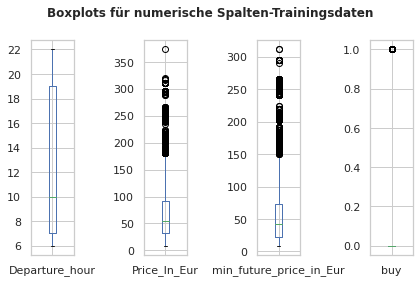

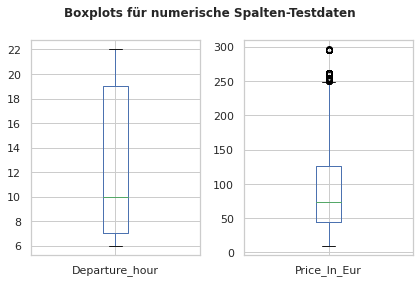

In [5]:
font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='bold',
                                   style='normal', size=12)
def Num_Spalten_visuals(dataframe, datentyp):
    
    cols = dataframe.columns
    new_col = []
    for col in cols:
        if (dataframe[col].dtypes == 'int64' or dataframe[col].dtypes == 'float64') and (col != 'index'):
            new_col.append(col)
    dataframe[new_col].plot(subplots=True,kind='box')
    plt.suptitle('Boxplots für numerische Spalten'+ datentyp,fontproperties=font)
    plt.tight_layout()
    plt.show()    

Num_Spalten_visuals(flug_df,'-Trainingsdaten')
Num_Spalten_visuals(flug_df_test,'-Testdaten')


Aus dem obigen Diagramm können wir ableiten, dass die Spalten 'Price_in_Eur' und 'min_future_price_in_Eur' Ausreißer enthalten. Die Ausreißer liegen in Trainingsdaten liegen nach dem Wert "150" für min_future_price_in_Eur und nach ca "180" für Price_In_Eur".
Die Abflüge finden von 6 Uhr bis 22 Uhr statt. Für alle Abfragen gilt: Der günstigste Flug kostet 8,99 € und der teuerste 372,96

In [6]:
# Ermitteln wir die Zählwerte der Daten, die diesen Ausreißern in jedem Merkmal in Trainingsdaten entsprechen

print (f"'Price' feature Outliers:\n{flug_df[flug_df['Price_In_Eur']>180].count()}'\n'")
print (f"\n\n'min_future_price' feature Outliers:\n{flug_df[flug_df['min_future_price_in_Eur']>150].count()}'\n'")

'Price' feature Outliers:
index                      4881
Request_Date               4881
Flight_Date                4881
Departure_hour             4881
flight_unique_id           4881
route_abb                  4881
Price_In_Eur               4881
min_future_price_in_Eur    4881
buy                        4881
dtype: int64'
'


'min_future_price' feature Outliers:
index                      4300
Request_Date               4300
Flight_Date                4300
Departure_hour             4300
flight_unique_id           4300
route_abb                  4300
Price_In_Eur               4300
min_future_price_in_Eur    4300
buy                        4300
dtype: int64'
'


Wir stellen fest, dass es in jedem Merkmal nur 4881 Beobachtungen gibt, die den Ausreißerbeobachtungen des Merkmals 'Price_In_Eur' entsprechen, und 4300 Beobachtungen, die den Ausreißerbeobachtungen des Merkmals 'min_future_price_in_Eur' entsprechen. 

Wir möchten nun den Prozentsatz dieser Beobachtungen (Zeilen) ermitteln:

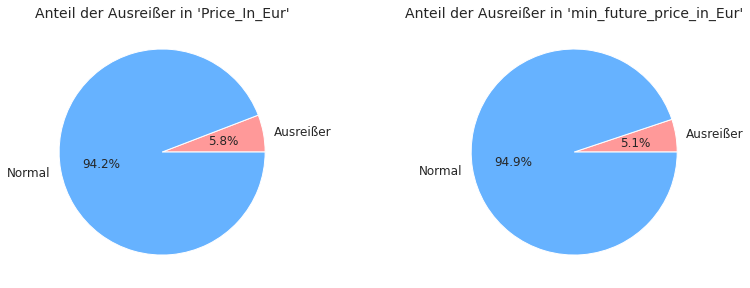

In [7]:
# Ermitteln wir die Prozentsätze der Daten, die diesen Ausreißern in jedem Merkmal in Trainingsdaten entsprechen

warnings.filterwarnings('ignore')

outliers_count_p = (flug_df['Price_In_Eur'] > 180).sum()
normal_count_p = len(flug_df) - outliers_count_p

outliers_count_m = (flug_df['min_future_price_in_Eur'] > 150).sum()
normal_count_m = len(flug_df) - outliers_count_m

# Diagramm erstellen
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie Chart für den Anteil der Ausreißer und des Normalfalls (Price_In_Eur)
labels_p = ['Ausreißer', 'Normal']
sizes_p = [outliers_count_p, normal_count_p]
colors_p = ['#FF9999', '#66B2FF']
axes[0].pie(sizes_p, labels=labels_p, colors=colors_p, autopct='%1.1f%%', textprops={'fontsize': 12})
axes[0].set_title("Anteil der Ausreißer in 'Price_In_Eur'", fontsize=14)

# Pie Chart für den Anteil der Ausreißer und des Normalfalls (min_future_price_in_Eur)
labels_m = ['Ausreißer', 'Normal']
sizes_m = [outliers_count_m, normal_count_m]
colors_m = ['#FF9999', '#66B2FF']
axes[1].pie(sizes_m, labels=labels_m, colors=colors_m, autopct='%1.1f%%', textprops={'fontsize': 12})
axes[1].set_title("Anteil der Ausreißer in 'min_future_price_in_Eur'", fontsize=14)

plt.subplots_adjust(wspace=0.6)
plt.show()


### Datentypkonvertierung

Wenn wir die Daten, die in den Spalten vorkommen mit ihren Datentypen vergleichen, stellt man fest, dass einige Feautures nicht der richtige Datentyp haben. Die beiden Feautures 'Request_Date'und 'Flight_Date' sollten vom Datentyp 'datetime' sein. Der Feature 'Request_Date' ist im UTC-Format gespeichert, Deswegen muss er erstmal in Localen Format umkonvertiert werden.

Der Datentyp des Features 'buy' wird später auch für das Training in den Datentyp 'category' konvertiert, da es sich hierbei um die vorherzusagende Klasse handelt.

In [8]:

def local_time(row):
    if row['route_abb'].split('-')[0] == 'SXF' or row['route_abb'].split('-')[0] == 'FRA':
        # Zeitzone
        zone = "Europe/Berlin"
    else:
        # Zeitzone
        zone = "Europe/London"
    
    # Konvertierung in ein datetime-Objekt
    dtUTC = datetime.strptime(row['Request_Date'], '%Y-%m-%dT%H:%M:%SZ')
    dtZone = dtUTC.replace(tzinfo=tz.gettz('UTC')).astimezone(tz.gettz(zone))
    
    # Formatierung des DateTime-Strings ohne Zeitzonen-Offset-Information
    dtString = dtZone.strftime('%Y-%m-%d %H:%M:%S')
    
    # Rückgabe des konvertierten Werts
    return pd.to_datetime(dtString)

# Konvertierung Trainingsdaten
flug_df['Request_Date'] = flug_df.apply( local_time, axis=1)
flug_df['Flight_Date']= pd.to_datetime(flug_df['Flight_Date'])
#flug_df['buy']= flug_df['buy'].astype('category')

# Konvertierung Trainingsdaten
flug_df_test['Request_Date'] = flug_df_test.apply( local_time, axis=1) 
flug_df_test['Flight_Date']= pd.to_datetime(flug_df['Flight_Date'])

print(f"Datentyp von Features nach Konvertierung: Trainingsdaten\n\n{flug_df.dtypes}")
print(f"\nDatentyp von Features nach Konvertierung: Testdaten\n\n{flug_df_test.dtypes}")

Datentyp von Features nach Konvertierung: Trainingsdaten

index                               int64
Request_Date               datetime64[ns]
Flight_Date                datetime64[ns]
Departure_hour                      int64
flight_unique_id                   object
route_abb                          object
Price_In_Eur                      float64
min_future_price_in_Eur           float64
buy                                 int64
dtype: object

Datentyp von Features nach Konvertierung: Testdaten

index                        int64
Request_Date        datetime64[ns]
Flight_Date         datetime64[ns]
Departure_hour               int64
flight_unique_id            object
route_abb                   object
Price_In_Eur               float64
dtype: object


### Korrelationen

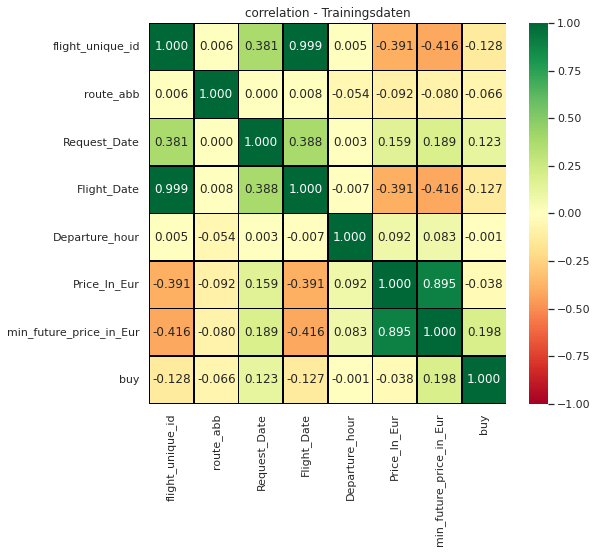

In [9]:
colcat = ['flight_unique_id', 'route_abb','Request_Date','Flight_Date']
colnum = ['Departure_hour','Price_In_Eur','min_future_price_in_Eur','buy']

#Erstellung numerischer Darstellungen von kategorialen Variablen in Trainingsdaten
df = flug_df[colcat].apply(lambda x : pd.factorize(x)[0])
df_concat = pd.concat([df,flug_df[colnum]], axis=1) 

# Berechnung der Korrelationsmatrix
corrmat=df_concat.corr(method='pearson')

# Visualisierung der Koorelationsmatrix
plt.figure(figsize=(8,7))
sns.heatmap(corrmat, annot=True,
            fmt='.3f',
            linecolor='black', linewidths=.5,
            cmap='RdYlGn', vmin=-1, vmax=+1)
plt.title('correlation - Trainingsdaten')
plt.show()

Die Korrelation zeigt, dass die beiden Merkmale 'Price_in_Eur' und 'min_future_price_in_Eur' stark korreliert sind und ein proportionalen Verhältnis aufweisen. Wenn der Wert von 'Price_in_Eur' steigt, steigt auch der Wert von 'min_future_price_in_Eur'.

## **Explorative Analyse**

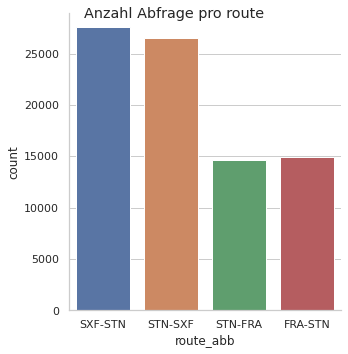

In [10]:
#Wie viele Abfragen haben wir pro Route in Trainingsdaten?
cp = sns.catplot(x='route_abb', data=flug_df,kind='count')
cp.fig.suptitle('Anzahl Abfrage pro route')
plt.show()


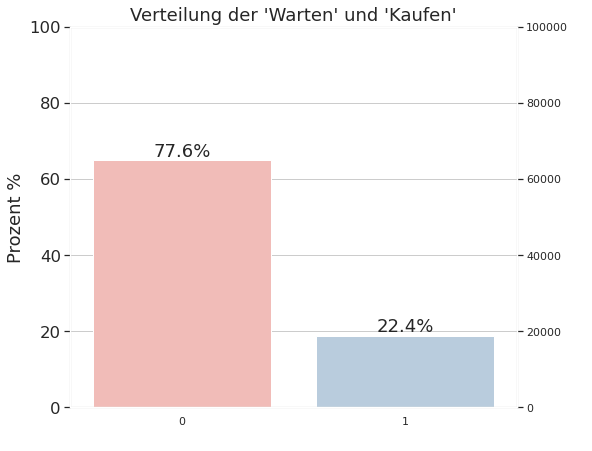

In [11]:
def default():
    ncount = len(flug_df)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Prozent %')
    plt.title("Verteilung der 'Warten' und 'Kaufen'")

    for i in ax.patches:
        x=i.get_bbox().get_points()[:,0]
        y=i.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

ax = sns.countplot(x=flug_df.buy, palette="Pastel1")
sns.set(font_scale=1.5)
ax.set_ylim(top=100000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,7)
ax.set_ylim(top=100000)

default()

plt.show()


Dadurch stellt man fest, dass der Datensatz unbalanciert ist. Wir haben 64906 warten und nur 18718 kaufen. Was uns schon der Hinweis gibt, dass bei Aufteilen in Trainings- und Validierungsset Stratifizierung verwenden sollten.

In [12]:
route_SXF_STN = flug_df.loc[flug_df['route_abb'] =='SXF-STN', 'Price_In_Eur']
route_STN_SXF= flug_df.loc[flug_df['route_abb'] =='STN-SXF', 'Price_In_Eur']
route_STN_FRA = flug_df.loc[flug_df['route_abb'] =='STN-FRA', 'Price_In_Eur']
route_FRA_STN = flug_df.loc[flug_df['route_abb'] =='FRA-STN', 'Price_In_Eur']
print("Der Mittelpreis liegt bei {}".format(round(route_SXF_STN.mean(), 2)), "wenn man der Preis von Berlin nach London abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_SXF.mean(), 2)), "wenn man der Preis von London nach Berlin  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_STN_FRA.mean(), 2)), "wenn man der Preis von London nach Frankfurt  abfragt")
print("Der Mittelpreis liegt bei {}".format(round(route_FRA_STN.mean(), 2)), "wenn man der Preis von Frankfurt nach London abfragt")

Der Mittelpreis liegt bei 74.79 wenn man der Preis von Berlin nach London abfragt
Der Mittelpreis liegt bei 77.38 wenn man der Preis von London nach Berlin  abfragt
Der Mittelpreis liegt bei 67.57 wenn man der Preis von London nach Frankfurt  abfragt
Der Mittelpreis liegt bei 61.45 wenn man der Preis von Frankfurt nach London abfragt


Das würde bedeuten es ist güngstiger in Richtung London der Flugticket von Frankfurt zu buchen und für die Rückreise nach Deutschland ist es auch günstiger in Frankfurt zu landen. Das wird durch die untere Visualisierung veranschaulicht.

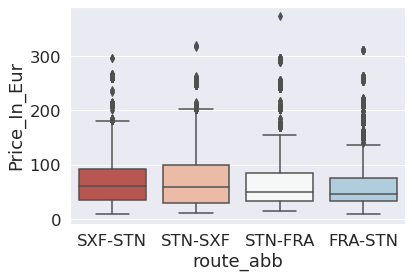

In [13]:
sns.boxplot(x = 'route_abb', y =flug_df['Price_In_Eur'], data = flug_df, palette = sns.color_palette('RdBu',5))
plt.show()

## **Feature ingeneering**

In [14]:
def generate_features(dataframe):
    #eine Reihe von Merkmalen unter Verwendung der Datumsspalten erstellen
    dataframe.loc[:,'Request_date'] = dataframe['Request_Date'].dt.date
    dataframe.loc[:,'Request_time'] = dataframe['Request_Date'].dt.time
    dataframe.loc[:,'days_diff'] = (pd.to_datetime(dataframe['Flight_Date'])- pd.to_datetime(dataframe['Request_date'])).dt.days
    #dataframe.loc[:,'flight_Date'] = dataframe['Flight_Date'].dt.dayofweek
    #dataframe.loc[:,'month'] = dataframe['Flight_Date'].dt.month
    #dataframe.loc[:,'weekofyear'] = dataframe['Flight_Date'].dt.isocalendar().week
    
    # Umrechnung der Departure_hour in Vormittag/Nachmittag/Abend usw.
    s = (dataframe["Departure_hour"] % 24 + 4) // 4 #give numbers from 1 to 6 #(return a series)
    # Werte ersetzen 1:latenight to 6: night
    s.replace({1: 'Late Night', 2: 'Early Morning', 3: 'Morning', 
                      4: 'Afternoon', 5: 'Evening', 6: 'Night'} ,inplace = True) 
    dataframe["departure_time"] = s
    dataframe['source'] =''
    dataframe['destination'] =''

    #Die Merkmales source und destination aus dem Spalten route_abb erstellen
    unique_routes = dataframe['route_abb'].unique()
    for route in unique_routes:
        if route == 'SXF-STN':
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Berlin'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
        elif route == 'STN-SXF':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Berlin'
        elif route == 'STN-FRA':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'London'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'Frankfurt'
        elif route == 'FRA-STN':  # Weitere Ausprägungen hinzufügen
            dataframe.loc[dataframe['route_abb'] == route, 'source'] = 'Frankfurt'
            dataframe.loc[dataframe['route_abb'] == route, 'destination'] = 'London'
    return dataframe

In [15]:
# einen aggregierten Datenrahmen erstellen, um die Informationen über die Preise für jeweils einen Flug zu erhalten

def agg_Dataframe(df):
 # eine Reihe von Merkmalen unter Verwendung der Datumsspalte erstellen
    df['year'] = df['Flight_Date'].dt.year
    df['weekofyear'] = df['Flight_Date'].dt.isocalendar().week
    df['month'] = df['Flight_Date'].dt.month
    df['dayofweek'] = df['Flight_Date'].dt.dayofweek
    df['weekend'] = (df['Flight_Date'].dt.weekday >=5).astype(int)
 
 # ein aggregate dictionary erstellen
    aggs = {}
 
 # nach Price_In_Eur und die Aggregate sum, max, min 
 # and mean für den Merkmal berechnen
    aggs['Price_In_Eur'] = ['sum','max','min','mean']
    aggs['Request_Date'] = ['size']
    aggs['min_future_price_in_Eur'] = ['mean']

    
 # nach flight_unique_id gruppieren und die Aggregate berechnen
    agg_df = df.groupby('flight_unique_id').agg(aggs)

 # die Spaltennamen abflachen
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    
# index zurücksetzen
    agg_df = agg_df.reset_index()

# aggregierte Dataframe zurückgeben    
    return agg_df

In [16]:
flug_df_agg = agg_Dataframe(flug_df)
flug_df_agg

,flight_unique_id,Price_In_Eur_sum,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Request_Date_size,min_future_price_in_Eur_mean
0,2019-06-05 FR 146,985.28,259.07,208.07,246.320000,4,259.070000
1,2019-06-05 FR 147,899.36,252.06,143.86,224.840000,4,251.720000
2,2019-06-05 FR 8545,123.88,50.99,22.17,30.970000,4,38.175000
3,2019-06-06 FR 144,269.24,73.43,61.19,67.310000,4,61.190000
4,2019-06-06 FR 146,1104.61,259.07,149.93,220.922000,5,149.930000
...,...,...,...,...,...,...,...
1002,2019-09-09 FR 8545,5945.00,92.73,19.99,48.729508,122,39.590984
1003,2019-09-10 FR 144,2612.82,50.99,9.99,21.242439,123,15.007154
1004,2019-09-10 FR 145,2725.44,35.13,11.21,22.158049,123,15.829187
1005,2019-09-10 FR 8542,2324.74,24.64,11.21,18.900325,123,13.551138


In [17]:
flug_df_agg = agg_Dataframe(flug_df)

# Trainingsdaten und aggregierte Dataframe verknüpfen
Trainingsdaten = flug_df_agg.merge(generate_features(flug_df))

In [18]:
Trainingsdaten.drop(columns=['index','Request_Date','route_abb'],axis=1,inplace=True)

In [19]:
Trainingsdaten

,flight_unique_id,Price_In_Eur_sum,Price_In_Eur_max,Price_In_Eur_min,Price_In_Eur_mean,Request_Date_size,min_future_price_in_Eur_mean,Flight_Date,Departure_hour,Price_In_Eur,min_future_price_in_Eur,buy,year,weekofyear,month,dayofweek,weekend,Request_date,Request_time,days_diff,departure_time,source,destination
0,2019-06-05 FR 146,985.28,259.07,208.07,246.320000,4,259.070000,2019-06-05,19,208.07,259.07,1,2019,23,6,2,0,2019-06-03,13:00:00,2,Evening,Berlin,London
1,2019-06-05 FR 146,985.28,259.07,208.07,246.320000,4,259.070000,2019-06-05,19,259.07,259.07,1,2019,23,6,2,0,2019-06-04,01:00:00,1,Evening,Berlin,London
2,2019-06-05 FR 146,985.28,259.07,208.07,246.320000,4,259.070000,2019-06-05,19,259.07,259.07,1,2019,23,6,2,0,2019-06-04,13:00:00,1,Evening,Berlin,London
3,2019-06-05 FR 146,985.28,259.07,208.07,246.320000,4,259.070000,2019-06-05,19,259.07,259.07,1,2019,23,6,2,0,2019-06-05,01:00:00,0,Evening,Berlin,London
4,2019-06-05 FR 147,899.36,252.06,143.86,224.840000,4,251.720000,2019-06-05,21,143.86,251.72,1,2019,23,6,2,0,2019-06-03,12:00:00,2,Night,London,Berlin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83619,2019-09-10 FR 8543,3166.64,54.99,9.99,25.745041,123,14.499106,2019-09-10,10,35.69,39.69,1,2019,37,9,1,0,2019-08-01,13:00:00,40,Morning,Berlin,London
83620,2019-09-10 FR 8543,3166.64,54.99,9.99,25.745041,123,14.499106,2019-09-10,10,46.83,39.69,0,2019,37,9,1,0,2019-08-02,01:00:00,39,Morning,Berlin,London
83621,2019-09-10 FR 8543,3166.64,54.99,9.99,25.745041,123,14.499106,2019-09-10,10,46.83,39.69,0,2019,37,9,1,0,2019-08-02,13:00:00,39,Morning,Berlin,London
83622,2019-09-10 FR 8543,3166.64,54.99,9.99,25.745041,123,14.499106,2019-09-10,10,39.69,39.69,1,2019,37,9,1,0,2019-08-03,01:00:00,38,Morning,Berlin,London
